In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

Valores nulos por columna:
 id                                     0
name                                   0
host_id                                0
host_name                             32
neighbourhood_group                    0
neighbourhood                          0
latitude                               0
longitude                              0
room_type                              0
price                              37372
minimum_nights                         0
number_of_reviews                      0
last_review                        47237
reviews_per_month                  47237
calculated_host_listings_count         0
availability_365                       0
number_of_reviews_ltm                  0
license                           125016
month                                  0
state                                  0
dtype: int64
                  id                                               name  \
count   2.146370e+05                                            

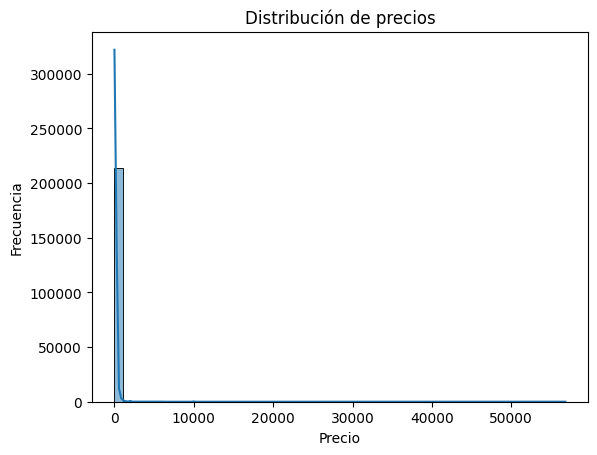

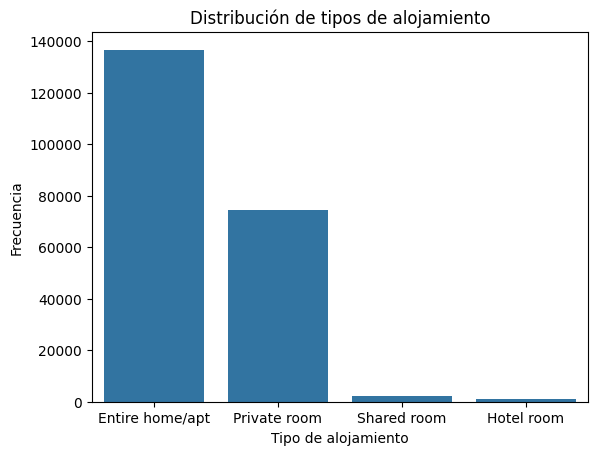

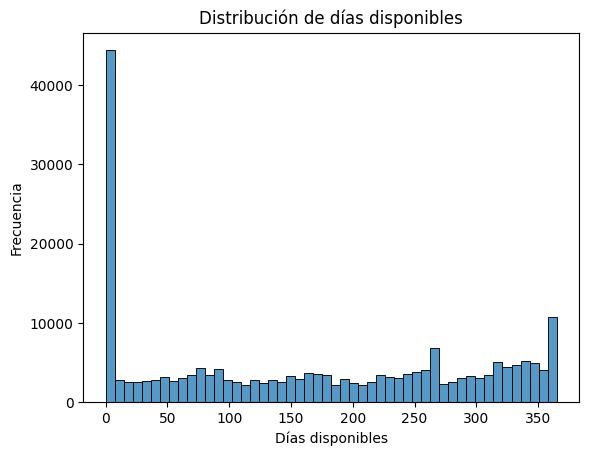

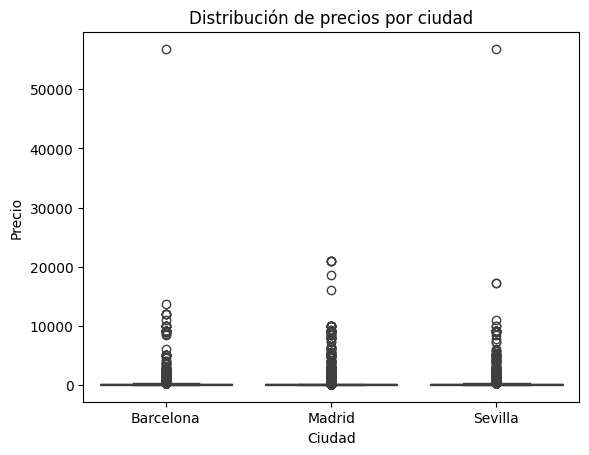

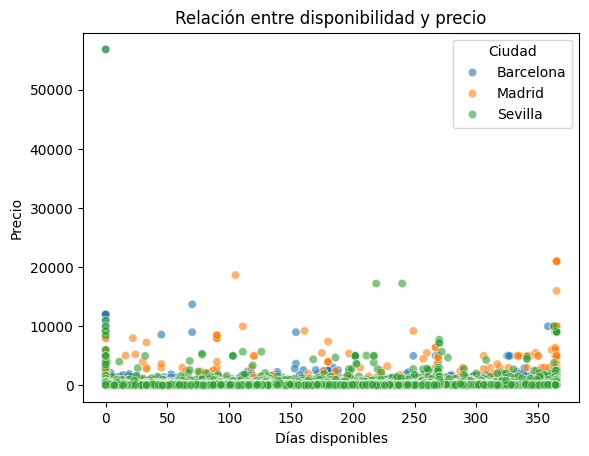

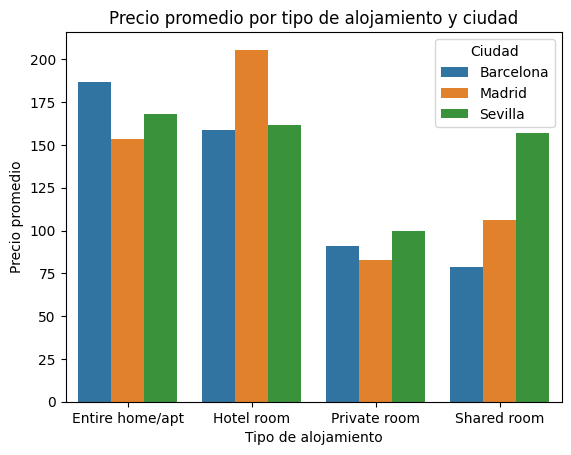

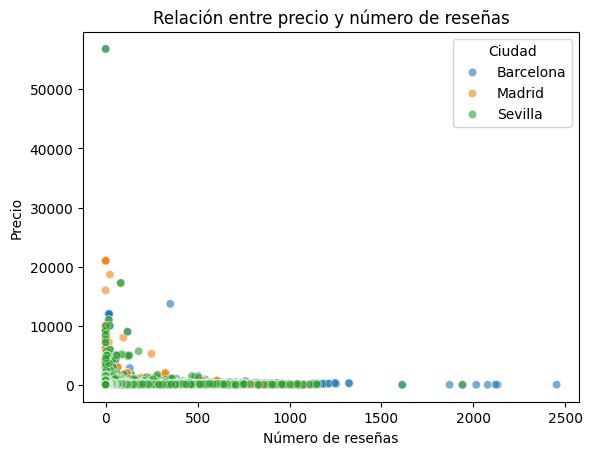

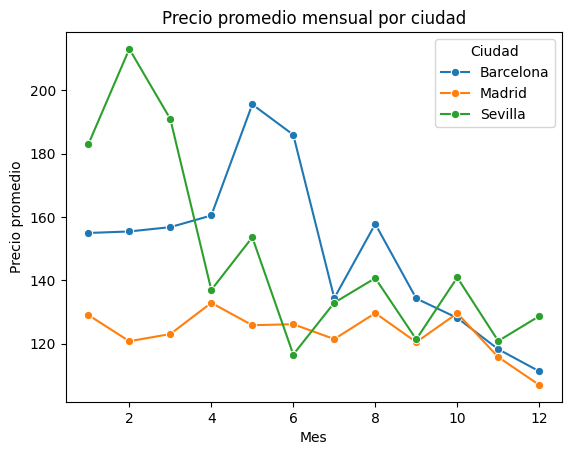

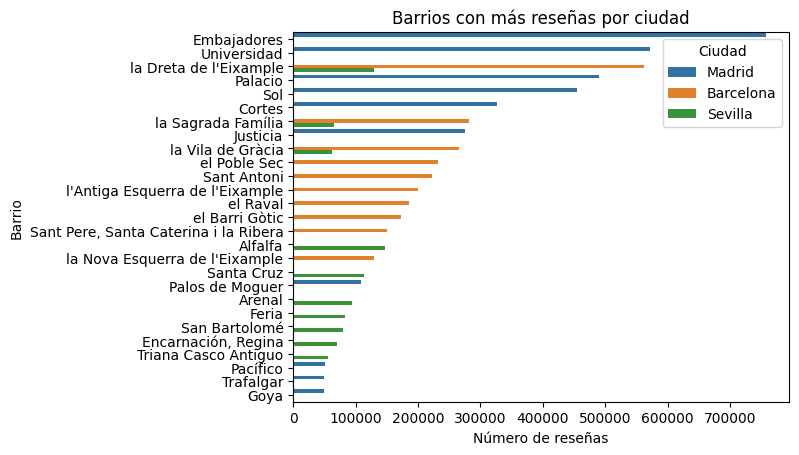

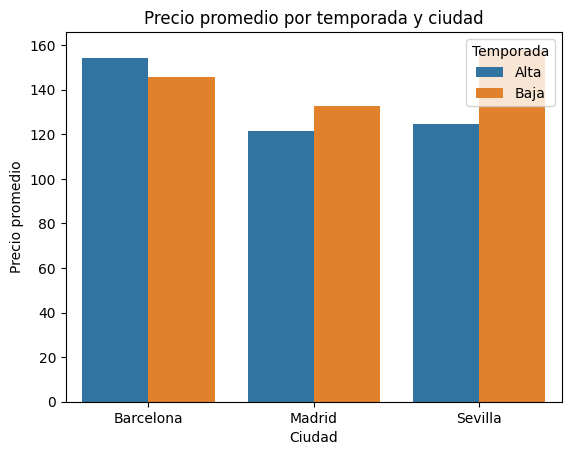

Estructura de cluster_data: (303, 2)
Primeras filas de cluster_data:
 season                  Alta        Baja
neighbourhood                           
Abrantes           57.685714   63.715909
Acacias            98.650430  107.709220
Adelfas           105.913669   91.287500
Aeropuerto         68.307692   72.920000
Aeropuerto Viejo  164.666667   92.500000


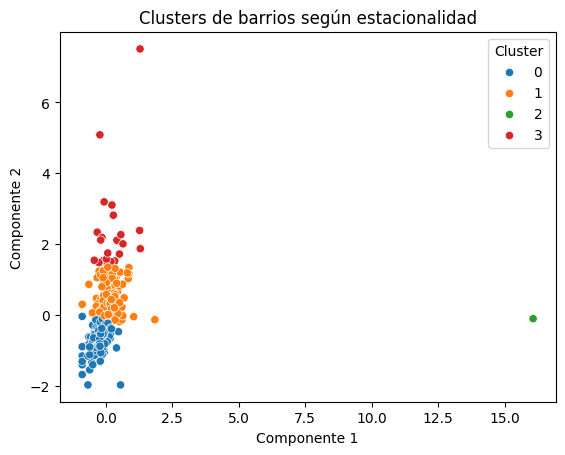

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     213.8
Date:                Mon, 16 Dec 2024   Prob (F-statistic):          1.74e-138
Time:                        10:37:53   Log-Likelihood:            -1.5517e+06
No. Observations:              214637   AIC:                         3.103e+06
Df Residuals:                  214633   BIC:                         3.103e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              122.0183      1.174  

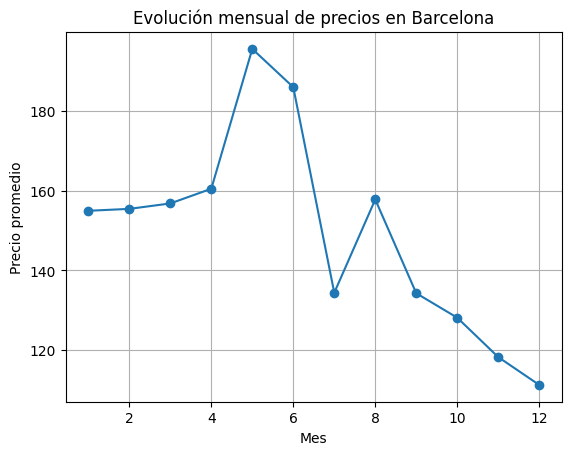

Madrid: T-Test: t-stat=-6.846309650043359, p-value=7.627214956901808e-12


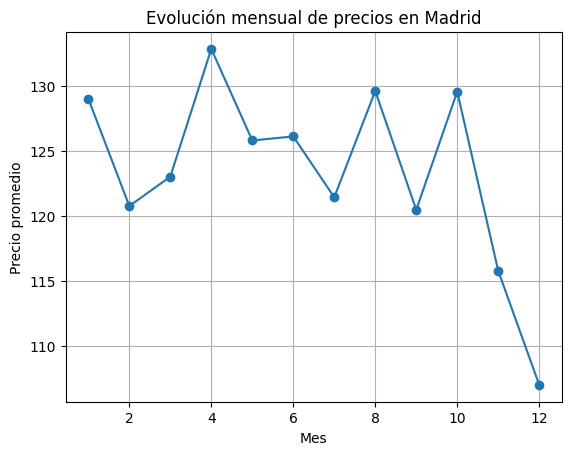

Sevilla: T-Test: t-stat=-7.644805331393558, p-value=2.1536953999584133e-14


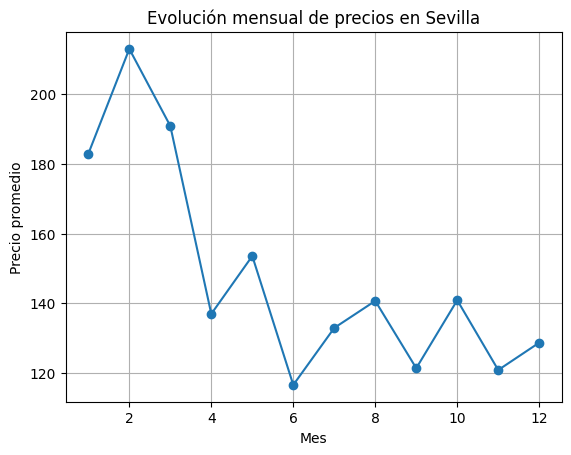

Mapa interactivo de Barcelona guardado como 'barcelona_map.html'.
Mapa interactivo de Madrid guardado como 'madrid_map.html'.
Mapa interactivo de Sevilla guardado como 'sevilla_map.html'.


In [4]:

# Cargar datos
data = pd.read_csv(r'C:\Users\alber\OneDrive\Documentos\GitHub\DS_ONLINE_THEBRIDGE_ATC\Project_Break_EDA\Data\DataSetConjunto')

# =============================
# Limpieza de datos
# =============================
# Identificar valores nulos
missing_values = data.isnull().sum()
print("Valores nulos por columna:\n", missing_values)

# Rellenar valores nulos en columnas importantes
data['price'] = data['price'].fillna(data['price'].median())
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

# Eliminar columnas innecesarias (si aplica)
data = data.drop(columns=['license'], errors='ignore')

# Crear columnas adicionales útiles:
data['month'] = pd.to_datetime(data['last_review'], errors='coerce').dt.month


# 1. ANÁLISIS UNIVARIANTE
# ========================
# Descripción general de las variables
data_summary = data.describe(include='all')
print(data_summary)

# Proporción de tipos de alojamiento
sns.countplot(x='room_type', data=data, order=data['room_type'].value_counts().index)
plt.title("Distribución de tipos de alojamiento")
plt.xlabel("Tipo de alojamiento")
plt.ylabel("Frecuencia")
plt.show()

# Análisis de disponibilidad
sns.histplot(data['availability_365'], bins=50, kde=False)
plt.title("Distribución de días disponibles")
plt.xlabel("Días disponibles")
plt.ylabel("Frecuencia")
plt.show()

# Distribución de precios por ciudad
sns.boxplot(x='state', y='price', data=data)
plt.title("Distribución de precios por ciudad")
plt.xlabel("Ciudad")
plt.ylabel("Precio")
plt.show()

# 2. ANÁLISIS BIVARIANTE
# =======================
# Relación entre precio y disponibilidad
sns.scatterplot(x='availability_365', y='price', data=data, hue='state', alpha=0.6)
plt.title("Relación entre disponibilidad y precio")
plt.xlabel("Días disponibles")
plt.ylabel("Precio")
plt.legend(title="Ciudad")
plt.show()

# Precios promedio por tipo de alojamiento
room_price = data.groupby(['state', 'room_type'])['price'].mean().reset_index()
sns.barplot(data=room_price, x='room_type', y='price', hue='state')
plt.title("Precio promedio por tipo de alojamiento y ciudad")
plt.xlabel("Tipo de alojamiento")
plt.ylabel("Precio promedio")
plt.legend(title="Ciudad")
plt.show()

# Relación entre precio y número de reseñas
sns.scatterplot(x='number_of_reviews', y='price', data=data, hue='state', alpha=0.6)
plt.title("Relación entre precio y número de reseñas")
plt.xlabel("Número de reseñas")
plt.ylabel("Precio")
plt.legend(title="Ciudad")
plt.show()

# 3. ANÁLISIS MULTIVARIANTE
# ==========================
# Precios por mes y ciudad
price_by_month = data.groupby(['state', 'month'])['price'].mean().reset_index()
sns.lineplot(data=price_by_month, x='month', y='price', hue='state', marker='o')
plt.title("Precio promedio mensual por ciudad")
plt.xlabel("Mes")
plt.ylabel("Precio promedio")
plt.legend(title="Ciudad")
plt.show()

# Distribución de reseñas por barrio y ciudad
reviews_by_neighbourhood = data.groupby(['state', 'neighbourhood'])['number_of_reviews'].sum().reset_index()
reviews_top_neighbourhoods = reviews_by_neighbourhood.sort_values(by='number_of_reviews', ascending=False).groupby('state').head(10)
sns.barplot(data=reviews_top_neighbourhoods, y='neighbourhood', x='number_of_reviews', hue='state')
plt.title("Barrios con más reseñas por ciudad")
plt.xlabel("Número de reseñas")
plt.ylabel("Barrio")
plt.legend(title="Ciudad")
plt.show()

# Segmentación por temporadas
data['season'] = data['month'].apply(lambda x: 'Alta' if x in [6, 7, 8, 12] else 'Baja')
season_prices = data.groupby(['state', 'season'])['price'].mean().reset_index()
sns.barplot(data=season_prices, x='state', y='price', hue='season')
plt.title("Precio promedio por temporada y ciudad")
plt.xlabel("Ciudad")
plt.ylabel("Precio promedio")
plt.legend(title="Temporada")
plt.show()

# Clustering de barrios según comportamiento estacional
cluster_data = data.groupby(['neighbourhood', 'season'])['price'].mean().unstack().fillna(0)

# Verificación de la estructura de cluster_data
print("Estructura de cluster_data:", cluster_data.shape)
print("Primeras filas de cluster_data:\n", cluster_data.head())

# Asegúrate de que hay más de una columna para realizar el clustering
if cluster_data.shape[1] > 1:
    # Escalado de los datos
    scaler = StandardScaler()
    cluster_scaled = scaler.fit_transform(cluster_data)

    # KMeans clustering
    kmeans = KMeans(n_clusters=4, random_state=42).fit(cluster_scaled)
    cluster_data['Cluster'] = kmeans.labels_

    # Visualización de clusters
    sns.scatterplot(x=cluster_scaled[:, 0], y=cluster_scaled[:, 1], hue=kmeans.labels_, palette='tab10')
    plt.title("Clusters de barrios según estacionalidad")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.legend(title="Cluster")
    plt.show()
else:
    print("No hay suficientes columnas para realizar el clustering.")

# Regresión múltiple para impacto de ubicación
data['latitude_scaled'] = StandardScaler().fit_transform(data[['latitude']])
data['longitude_scaled'] = StandardScaler().fit_transform(data[['longitude']])
X = data[['latitude_scaled', 'longitude_scaled', 'availability_365']]
y = data['price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# Análisis por ciudad
for city in ['Barcelona', 'Madrid', 'Sevilla']:
    city_data = data[data['state'] == city]
    
    # Comparación de precios entre temporadas
    high_season = city_data[city_data['season'] == 'Alta']['price']
    low_season = city_data[city_data['season'] == 'Baja']['price']
    t_stat, p_val = ttest_ind(high_season, low_season, equal_var=False)
    print(f"{city}: T-Test: t-stat={t_stat}, p-value={p_val}")

    # Evolución mensual
    monthly_prices = city_data.groupby('month')['price'].mean()
    plt.plot(monthly_prices.index, monthly_prices.values, marker='o')
    plt.title(f"Evolución mensual de precios en {city}")
    plt.xlabel("Mes")
    plt.ylabel("Precio promedio")
    plt.grid()
    plt.show()

# 5. VISUALIZACIÓN GEOGRÁFICA
# ===========================
# Crear mapas interactivos por ciudad
for city in ['Barcelona', 'Madrid', 'Sevilla']:
    city_data = data[data['state'] == city]
    city_map = folium.Map(location=[city_data['latitude'].mean(), city_data['longitude'].mean()], zoom_start=12)
    for _, row in city_data.iterrows():
        folium.CircleMarker(
            location=(row['latitude'], row['longitude']),
            radius=2,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.5
        ).add_to(city_map)
    city_map.save(f'{city.lower()}_map.html')
    print(f"Mapa interactivo de {city} guardado como '{city.lower()}_map.html'.")
